In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import anndata
import scanpy as sc
from ALLCools.mcds import MCDS
from ALLCools.clustering import tsne, significant_pc_test, filter_regions, remove_black_list_region, lsi, binarize_matrix
from ALLCools.plot import *
import matplotlib as mpl
mpl.style.use('default')
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Helvetica'

from ALLCools.clustering import tsne, significant_pc_test, log_scale

In [2]:
metadata = pd.read_csv('../Chaligne2021NG/chaligne_metadata_malignancy.csv', index_col = 0)
metadata

,# reads (x10^6),# CpGs (x10^6),CG conversion rate,Sample,Type,umap_0,umap_1,leiden,CellAssignment,G1S,G2M,malignancy
cell,,,,,,,,,,,,
GBM_MGH105C_A1_S1_L008.ACAACC,2.711635,0.138506,99.8,MGH105,GBM,8.973802,9.680786,11,MES.1,-0.101640,0.062919,malignant
GBM_MGH105C_A1_S1_L008.ACAGAC,3.512013,0.185960,99.8,MGH105,GBM,12.042452,9.953640,1,MES.2,-0.117634,0.060214,malignant
GBM_MGH105C_A1_S1_L008.ACTCAC,3.126639,0.170350,99.8,MGH105,GBM,11.322294,10.273609,1,MES.1,-0.275127,-0.044134,malignant
GBM_MGH105C_A1_S1_L008.AGAAGG,5.256122,0.192675,99.8,MGH105,GBM,11.336943,10.075572,1,NPC.1,-0.056924,0.120614,malignant
GBM_MGH105C_A1_S1_L008.AGGATG,3.158509,0.132072,99.8,MGH105,GBM,11.255992,8.218381,1,AC,-0.092281,-0.215080,malignant
...,...,...,...,...,...,...,...,...,...,...,...,...
MGH211_G1_S4_L008.ACAGAC,3.931381,0.259704,99.8,MGH211,GBM,12.420561,11.547959,12,AC,-0.588190,-0.882253,malignant
MGH211_G1_S4_L008.TATCTC,4.158703,0.206940,99.8,MGH211,GBM,10.751922,13.455838,6,NPC.2,-0.413245,-0.647870,malignant
MGH211_G1_S4_L008.TCTCTG,5.174613,0.263202,99.8,MGH211,GBM,13.212517,11.855555,12,MES.2,-0.471368,-0.644828,malignant


In [3]:
mcds = MCDS.open('../Chaligne2021NG/Chaligne2021NG/Chaligne2021NG.mcds/', var_dim='chrom100k')
mcds

<xarray.MCDS>
Dimensions:          (cell: 1583, chrom100k: 30895, count_type: 2)
Coordinates:
  * cell             (cell) <U38 'GBM_MGH105C_A1_S1_L008.ACAACC' ... 'MGH211_...
  * chrom100k        (chrom100k) <U10 'chr1_0' 'chr1_1' ... 'chrY_572'
    chrom100k_chrom  (chrom100k) <U5 dask.array<chunksize=(30895,), meta=np.ndarray>
    chrom100k_end    (chrom100k) int64 dask.array<chunksize=(30895,), meta=np.ndarray>
    chrom100k_start  (chrom100k) int64 dask.array<chunksize=(30895,), meta=np.ndarray>
  * count_type       (count_type) <U3 'mc' 'cov'
    mc_type          <U3 'CGN'
Data variables:
    chrom100k_da     (cell, chrom100k, count_type) uint32 dask.array<chunksize=(1583, 6179, 2), meta=np.ndarray>
Attributes:
    obs_dim:  cell
    var_dim:  chrom100k

In [4]:
mcds.add_cell_metadata(metadata)
selc = metadata.index
mcds = mcds.sel(cell = mcds.get_index('cell').intersection(selc))
mcds = mcds.remove_black_list_region(black_list_path='/gale/netapp/home/hanliu/ref/blacklist/hg38-blacklist.v2.bed.gz')


2408 chrom100k features removed due to overlapping (bedtools intersect -f 0.2) with black list regions.


# calculate chromosome mcg fraction

In [6]:
mcds_chr = mcds.sel(chrom100k= (mcds['chrom100k_chrom'].values=='chr10'))
mcg_df = mcds_chr.sel(count_type = 'mc').sum(dim='chrom100k').to_pandas()
covcg_df = mcds_chr.sel(count_type = 'cov').sum(dim='chrom100k').to_pandas()
chr10 = mcg_df['chrom100k_da'].div(covcg_df['chrom100k_da'])
chr10

cell
GBM_MGH105C_A1_S1_L008.ACAACC    0.509337
GBM_MGH105C_A1_S1_L008.ACAGAC    0.537347
GBM_MGH105C_A1_S1_L008.ACTCAC    0.500177
GBM_MGH105C_A1_S1_L008.AGAAGG    0.497501
GBM_MGH105C_A1_S1_L008.AGGATG    0.501436
                                   ...   
MGH211_G1_S4_L008.ACAGAC         0.483206
MGH211_G1_S4_L008.TATCTC         0.488276
MGH211_G1_S4_L008.TCTCTG         0.484961
MGH211_G1_S4_L008.TGACAG         0.508846
MGH211_G1_S4_L008.TGCTGC         0.586062
Name: chrom100k_da, Length: 1578, dtype: float64

In [7]:
chr10 = pd.DataFrame(chr10)
chr10.columns = ['chr10_mcg']
chr10

,chr10_mcg
cell,
GBM_MGH105C_A1_S1_L008.ACAACC,0.509337
GBM_MGH105C_A1_S1_L008.ACAGAC,0.537347
GBM_MGH105C_A1_S1_L008.ACTCAC,0.500177
GBM_MGH105C_A1_S1_L008.AGAAGG,0.497501
GBM_MGH105C_A1_S1_L008.AGGATG,0.501436
...,...
MGH211_G1_S4_L008.ACAGAC,0.483206
MGH211_G1_S4_L008.TATCTC,0.488276
MGH211_G1_S4_L008.TCTCTG,0.484961


In [8]:
mcds_chr = mcds.sel(chrom100k= (mcds['chrom100k_chrom'].values=='chr1'))
mcg_df = mcds_chr.sel(count_type = 'mc').sum(dim='chrom100k').to_pandas()
covcg_df = mcds_chr.sel(count_type = 'cov').sum(dim='chrom100k').to_pandas()
chrm =pd.DataFrame( mcg_df['chrom100k_da'].div(covcg_df['chrom100k_da']))
chrm.columns = ['chr1_mcg']
chr10 = chr10.join(chrm)
mcds_chr = mcds.sel(chrom100k= (mcds['chrom100k_chrom'].values=='chr7'))
mcg_df = mcds_chr.sel(count_type = 'mc').sum(dim='chrom100k').to_pandas()
covcg_df = mcds_chr.sel(count_type = 'cov').sum(dim='chrom100k').to_pandas()
chrm = pd.DataFrame(mcg_df['chrom100k_da'].div(covcg_df['chrom100k_da']))
chrm.columns = ['chr7_mcg']
chr10 = chr10.join(chrm)
chr10

,chr10_mcg,chr1_mcg,chr7_mcg
cell,,,
GBM_MGH105C_A1_S1_L008.ACAACC,0.509337,0.516327,0.528634
GBM_MGH105C_A1_S1_L008.ACAGAC,0.537347,0.474887,0.514112
GBM_MGH105C_A1_S1_L008.ACTCAC,0.500177,0.499771,0.531568
GBM_MGH105C_A1_S1_L008.AGAAGG,0.497501,0.463936,0.523910
GBM_MGH105C_A1_S1_L008.AGGATG,0.501436,0.475113,0.520439
...,...,...,...
MGH211_G1_S4_L008.ACAGAC,0.483206,0.449694,0.478244
MGH211_G1_S4_L008.TATCTC,0.488276,0.459788,0.483681
MGH211_G1_S4_L008.TCTCTG,0.484961,0.437420,0.493281


In [11]:
metadata

,# reads (x10^6),# CpGs (x10^6),CG conversion rate,Sample,Type,umap_0,umap_1,leiden,CellAssignment,G1S,G2M,malignancy
cell,,,,,,,,,,,,
GBM_MGH105C_A1_S1_L008.ACAACC,2.711635,0.138506,99.8,MGH105,GBM,8.973802,9.680786,11,MES.1,-0.101640,0.062919,malignant
GBM_MGH105C_A1_S1_L008.ACAGAC,3.512013,0.185960,99.8,MGH105,GBM,12.042452,9.953640,1,MES.2,-0.117634,0.060214,malignant
GBM_MGH105C_A1_S1_L008.ACTCAC,3.126639,0.170350,99.8,MGH105,GBM,11.322294,10.273609,1,MES.1,-0.275127,-0.044134,malignant
GBM_MGH105C_A1_S1_L008.AGAAGG,5.256122,0.192675,99.8,MGH105,GBM,11.336943,10.075572,1,NPC.1,-0.056924,0.120614,malignant
GBM_MGH105C_A1_S1_L008.AGGATG,3.158509,0.132072,99.8,MGH105,GBM,11.255992,8.218381,1,AC,-0.092281,-0.215080,malignant
...,...,...,...,...,...,...,...,...,...,...,...,...
MGH211_G1_S4_L008.ACAGAC,3.931381,0.259704,99.8,MGH211,GBM,12.420561,11.547959,12,AC,-0.588190,-0.882253,malignant
MGH211_G1_S4_L008.TATCTC,4.158703,0.206940,99.8,MGH211,GBM,10.751922,13.455838,6,NPC.2,-0.413245,-0.647870,malignant
MGH211_G1_S4_L008.TCTCTG,5.174613,0.263202,99.8,MGH211,GBM,13.212517,11.855555,12,MES.2,-0.471368,-0.644828,malignant


In [12]:
mcg_chr10 = chr10.join(metadata[['malignancy','Sample','CellAssignment']])
mcg_chr10

,chr10_mcg,chr1_mcg,chr7_mcg,malignancy,Sample,CellAssignment
cell,,,,,,
GBM_MGH105C_A1_S1_L008.ACAACC,0.509337,0.516327,0.528634,malignant,MGH105,MES.1
GBM_MGH105C_A1_S1_L008.ACAGAC,0.537347,0.474887,0.514112,malignant,MGH105,MES.2
GBM_MGH105C_A1_S1_L008.ACTCAC,0.500177,0.499771,0.531568,malignant,MGH105,MES.1
GBM_MGH105C_A1_S1_L008.AGAAGG,0.497501,0.463936,0.523910,malignant,MGH105,NPC.1
GBM_MGH105C_A1_S1_L008.AGGATG,0.501436,0.475113,0.520439,malignant,MGH105,AC
...,...,...,...,...,...,...
MGH211_G1_S4_L008.ACAGAC,0.483206,0.449694,0.478244,malignant,MGH211,AC
MGH211_G1_S4_L008.TATCTC,0.488276,0.459788,0.483681,malignant,MGH211,NPC.2
MGH211_G1_S4_L008.TCTCTG,0.484961,0.437420,0.493281,malignant,MGH211,MES.2


# with normalization within cells

In [5]:
mcds.add_mc_frac(
normalize_per_cell=True,  # after calculating mC frac, per cell normalize the matrix
    clip_norm_value=10  # clip outlier values above 10 to 10
)

In [8]:
mcds['chrom100k_da_frac'].load()

/gale/netapp/home2/yuwu/miniconda3/envs/allcools/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


<xarray.DataArray 'chrom100k_da_frac' (cell: 11053, chrom100k: 28494, mc_type: 2)>
array([[[ 1.10148838,  0.08830935],
        [ 0.63365123,  1.68836229],
        [ 0.78231688, 10.        ],
        ...,
        [ 0.76472605,  0.16118347],
        [ 0.76471606,  0.825499  ],
        [ 0.59987324,  1.92733326]],

       [[ 0.61668452,  0.64236307],
        [ 0.51659068,  1.07212853],
        [ 0.65079534,  0.70594553],
        ...,
        [ 0.76088472,  0.38073664],
        [ 0.70292567,  0.92830244],
        [ 0.49130926,  0.98974776]],

       [[ 0.98639084,  0.44719975],
        [ 0.70917085,  0.65312329],
        [ 0.76972477,  1.26241142],
        ...,
...
        ...,
        [ 0.97388283,  0.70143464],
        [ 0.7178507 ,  0.37400117],
        [ 0.74764425,  0.3463932 ]],

       [[ 1.02031802,  0.72609482],
        [ 0.70451621,  0.95550597],
        [ 0.86651511,  0.54452393],
        ...,
        [ 1.06990411,  0.85301645],
        [ 0.8736072 ,  1.12021584],
        [ 0.92141558,  0.75672795]],

       [[ 0.59617456,  0.91630379],
        [ 0.92739111,  0.65047941],
        [ 0.77432418,  0.94365201],
        ...,
        [ 1.03905366,  0.64419517],
        [ 0.92751263,  0.45337039],
        [ 0.75316161,  0.63321192]]])
Coordinates: (12/107)
  * mc_type                   (mc_type) <U3 'CGN' 'CHN'
  * cell                      (cell) object 'GBM_BT00009_Plate1-1-J2-A13' ......
  * chrom100k                 (chrom100k) <U10 'chr1_8' 'chr1_9' ... 'chrY_265'
    chrom100k_chrom           (chrom100k) <U5 'chr1' 'chr1' ... 'chrY' 'chrY'
    chrom100k_end             (chrom100k) int64 900000 1000000 ... 26600000
    chrom100k_start           (chrom100k) int64 800000 900000 ... 26500000
    ...                        ...
    cell_chr19_3c             (cell) float64 -0.9634 -1.109 ... -0.9354 -1.513
    cell_chr20_3c             (cell) float64 -0.716 -0.7098 ... -0.8856 -0.683
    cell_chrX_3c              (cell) float64 -0.4042 -0.1144 ... -0.5174 -0.6492
    cell_chr21_3c             (cell) float64 -1.607 -1.569 ... -2.467 -2.227
    cell_chr22_3c             (cell) float64 -2.007 -1.864 ... -1.73 -1.599
    cell_type                 (cell) object 'malignant' ... 'malignant'

In [16]:
mch_adata = mcds.get_adata(mc_type='CHN',
                           var_dim='chrom100k',
                           select_hvf=False)
#log_scale(mch_adata)
mch_adata

/gale/netapp/home2/yuwu/miniconda3/envs/allcools/lib/python3.8/site-packages/ALLCools/mcds/mcds.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs_df[coord_prefix.sub("", k)] = series


AnnData object with n_obs × n_vars = 11053 × 28494
    obs: 'Plate', 'PCRIndex', 'MultiplexGroup', 'RandomIndex', 'Col384', 'Row384', 'R1InputReads', 'R1InputReadsBP', 'R1WithAdapters', 'R1QualTrimBP', 'R1TrimmedReads', 'R1TrimmedReadsBP', 'R1TrimmedReadsRate', 'R1UniqueMappedReads', 'R1DeduppedReads', 'R2InputReads', 'R2InputReadsBP', 'R2WithAdapters', 'R2QualTrimBP', 'R2TrimmedReads', 'R2TrimmedReadsBP', 'R2TrimmedReadsRate', 'R2UniqueMappedReads', 'R2DeduppedReads', 'CisShortContact', 'CisLongContact', 'TransContact', 'mCHmC', 'mCHCov', 'mCHFrac', 'mCGmC', 'mCGCov', 'mCGFrac', 'mCCCmC', 'mCCCCov', 'mCCCFrac', 'GenomeCov', 'LambdaCYFrac', 'LambdaCYCov', 'FinalmCReads', 'CellInputReadPairs', 'R1MappingRate', 'R2MappingRate', 'R1DuplicationRate', 'R2DuplicationRate', 'CellBarcodeRatio', 'TotalContacts', 'CisShortRatio', 'CisLongRatio', 'TransRatio', 'Sample', 'umap_0', 'umap_1', 'leiden', '5k_leiden', 'chr1mcgcov', 'chr2mcgcov', 'chr3mcgcov', 'chr4mcgcov', 'chr5mcgcov', 'chr6mcgcov', '

In [17]:
mcg_adata = mcds.get_adata(mc_type='CGN',
                           var_dim='chrom100k',
                           select_hvf=False)
#log_scale(mcg_adata)
mcg_adata

/gale/netapp/home2/yuwu/miniconda3/envs/allcools/lib/python3.8/site-packages/ALLCools/mcds/mcds.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs_df[coord_prefix.sub("", k)] = series


AnnData object with n_obs × n_vars = 11053 × 28494
    obs: 'Plate', 'PCRIndex', 'MultiplexGroup', 'RandomIndex', 'Col384', 'Row384', 'R1InputReads', 'R1InputReadsBP', 'R1WithAdapters', 'R1QualTrimBP', 'R1TrimmedReads', 'R1TrimmedReadsBP', 'R1TrimmedReadsRate', 'R1UniqueMappedReads', 'R1DeduppedReads', 'R2InputReads', 'R2InputReadsBP', 'R2WithAdapters', 'R2QualTrimBP', 'R2TrimmedReads', 'R2TrimmedReadsBP', 'R2TrimmedReadsRate', 'R2UniqueMappedReads', 'R2DeduppedReads', 'CisShortContact', 'CisLongContact', 'TransContact', 'mCHmC', 'mCHCov', 'mCHFrac', 'mCGmC', 'mCGCov', 'mCGFrac', 'mCCCmC', 'mCCCCov', 'mCCCFrac', 'GenomeCov', 'LambdaCYFrac', 'LambdaCYCov', 'FinalmCReads', 'CellInputReadPairs', 'R1MappingRate', 'R2MappingRate', 'R1DuplicationRate', 'R2DuplicationRate', 'CellBarcodeRatio', 'TotalContacts', 'CisShortRatio', 'CisLongRatio', 'TransRatio', 'Sample', 'umap_0', 'umap_1', 'leiden', '5k_leiden', 'chr1mcgcov', 'chr2mcgcov', 'chr3mcgcov', 'chr4mcgcov', 'chr5mcgcov', 'chr6mcgcov', '

In [39]:
chr10 = mcg_adata[:,mcg_adata.var['chrom']=='chr10']
mcg_chr10 = pd.DataFrame( {'chr10_mcg': chr10.X.mean(axis = 1)}, index = chr10.obs.index)
mcg_chr10 = mcg_chr10.join(metadata[['type','Sample','mCGmC', 'mCGCov', 'mCGFrac']])
mcg_chr10

,chr10_mcg,type,Sample,mCGmC,mCGCov,mCGFrac
cell,,,,,,
GBM_BT00009_Plate1-1-J2-A13,1.014008,malignant,GBM_BT00009,422258.0,617300.0,0.684040
GBM_BT00009_Plate1-1-J2-A14,0.997400,malignant,GBM_BT00009,1291647.0,1795842.0,0.719243
GBM_BT00009_Plate1-1-J2-A1,0.998946,non-malignant,GBM_BT00009,1385482.0,1742671.0,0.795034
GBM_BT00009_Plate1-1-J2-A2,1.001853,malignant,GBM_BT00009,1252881.0,1763582.0,0.710418
GBM_BT00009_Plate1-1-J2-B13,1.012557,malignant,GBM_BT00009,1201461.0,1717427.0,0.699570
...,...,...,...,...,...,...
BT0010_AR_Plate8-6-G10-O24,1.001359,malignant,BT0010_AR,1969466.0,2452807.0,0.802944
BT0010_AR_Plate8-6-G10-P11,1.000623,malignant,BT0010_AR,2241847.0,2845655.0,0.787814
BT0010_AR_Plate8-6-G10-P12,1.000125,malignant,BT0010_AR,2336266.0,2889914.0,0.808421


In [37]:
sample = 'CW_2209'
baseline = mcg_chr10[(mcg_chr10['type']=='non-malignant')&mcg_chr10['Sample']== sample]['chr10_mcg'].mean()
mcg_chr10['chr10mcg_cancer-normal'] = mcg_chr10['chr10_mcg'] - baseline
mcg_chr10

,chr10_mcg,chrom100k_da,chr1_mcg,chr7_mcg,type,Sample,mCGmC,mCGCov,mCGFrac,chr10mcg_cancer-normal
cell,,,,,,,,,,
GBM_BT00009_Plate1-1-J2-A13,0.713788,0.697112,0.697112,0.707027,malignant,GBM_BT00009,422258.0,617300.0,0.684040,-0.035546
GBM_BT00009_Plate1-1-J2-A14,0.725318,0.717297,0.717297,0.732899,malignant,GBM_BT00009,1291647.0,1795842.0,0.719243,-0.024017
GBM_BT00009_Plate1-1-J2-A1,0.803192,0.788260,0.788260,0.809572,non-malignant,GBM_BT00009,1385482.0,1742671.0,0.795034,0.053858
GBM_BT00009_Plate1-1-J2-A2,0.726865,0.708662,0.708662,0.724479,malignant,GBM_BT00009,1252881.0,1763582.0,0.710418,-0.022469
GBM_BT00009_Plate1-1-J2-B13,0.718965,0.705868,0.705868,0.719269,malignant,GBM_BT00009,1201461.0,1717427.0,0.699570,-0.030369
...,...,...,...,...,...,...,...,...,...,...
BT0010_AR_Plate8-6-G10-O24,0.826341,0.799069,0.799069,0.817509,malignant,BT0010_AR,1969466.0,2452807.0,0.802944,0.077007
BT0010_AR_Plate8-6-G10-P11,0.807804,0.788345,0.788345,0.804537,malignant,BT0010_AR,2241847.0,2845655.0,0.787814,0.058469
BT0010_AR_Plate8-6-G10-P12,0.830639,0.805095,0.805095,0.824319,malignant,BT0010_AR,2336266.0,2889914.0,0.808421,0.081304


In [38]:
mcg_df = mcg_chr10

In [ ]:
chr10 = mcg_adata[:,mcg_adata.var['chrom']=='chr7']
mcg_chr7 = pd.DataFrame( {'chr7_mcg': chr10.X.mean(axis = 1)}, index = chr10.obs.index)
mcg_chr10 = mcg_chr10.join(mcg_chr7)

In [39]:
baseline = mcg_chr10[mcg_chr10['type']=='non-malignant']['chr7_mcg'].mean()
mcg_chr10['chr7mcg_cancer-normal'] = mcg_chr10['chr7_mcg'] - baseline
mcg_chr10

,chr10_mcg,chrom100k_da,chr1_mcg,chr7_mcg,type,Sample,mCGmC,mCGCov,mCGFrac,chr10mcg_cancer-normal,chr7mcg_cancer-normal
cell,,,,,,,,,,,
GBM_BT00009_Plate1-1-J2-A13,0.713788,0.697112,0.697112,0.707027,malignant,GBM_BT00009,422258.0,617300.0,0.684040,-0.035546,-0.047869
GBM_BT00009_Plate1-1-J2-A14,0.725318,0.717297,0.717297,0.732899,malignant,GBM_BT00009,1291647.0,1795842.0,0.719243,-0.024017,-0.021997
GBM_BT00009_Plate1-1-J2-A1,0.803192,0.788260,0.788260,0.809572,non-malignant,GBM_BT00009,1385482.0,1742671.0,0.795034,0.053858,0.054676
GBM_BT00009_Plate1-1-J2-A2,0.726865,0.708662,0.708662,0.724479,malignant,GBM_BT00009,1252881.0,1763582.0,0.710418,-0.022469,-0.030417
GBM_BT00009_Plate1-1-J2-B13,0.718965,0.705868,0.705868,0.719269,malignant,GBM_BT00009,1201461.0,1717427.0,0.699570,-0.030369,-0.035627
...,...,...,...,...,...,...,...,...,...,...,...
BT0010_AR_Plate8-6-G10-O24,0.826341,0.799069,0.799069,0.817509,malignant,BT0010_AR,1969466.0,2452807.0,0.802944,0.077007,0.062613
BT0010_AR_Plate8-6-G10-P11,0.807804,0.788345,0.788345,0.804537,malignant,BT0010_AR,2241847.0,2845655.0,0.787814,0.058469,0.049641
BT0010_AR_Plate8-6-G10-P12,0.830639,0.805095,0.805095,0.824319,malignant,BT0010_AR,2336266.0,2889914.0,0.808421,0.081304,0.069424


In [ ]:
chr10 = mcg_adata[:,mcg_adata.var['chrom']=='chr1']
mcg_chr1 = pd.DataFrame( {'chr1_mcg': chr10.X.mean(axis = 1)}, index = chr10.obs.index)
mcg_chr10 = mcg_chr10.join(mcg_chr1)

In [40]:
baseline = mcg_chr10[mcg_chr10['type']=='non-malignant']['chr1_mcg'].mean()
mcg_chr10['chr1mcg_cancer-normal'] = mcg_chr10['chr1_mcg'] - baseline
mcg_chr10

,chr10_mcg,chrom100k_da,chr1_mcg,chr7_mcg,type,Sample,mCGmC,mCGCov,mCGFrac,chr10mcg_cancer-normal,chr7mcg_cancer-normal,chr1mcg_cancer-normal
cell,,,,,,,,,,,,
GBM_BT00009_Plate1-1-J2-A13,0.713788,0.697112,0.697112,0.707027,malignant,GBM_BT00009,422258.0,617300.0,0.684040,-0.035546,-0.047869,-0.036774
GBM_BT00009_Plate1-1-J2-A14,0.725318,0.717297,0.717297,0.732899,malignant,GBM_BT00009,1291647.0,1795842.0,0.719243,-0.024017,-0.021997,-0.016589
GBM_BT00009_Plate1-1-J2-A1,0.803192,0.788260,0.788260,0.809572,non-malignant,GBM_BT00009,1385482.0,1742671.0,0.795034,0.053858,0.054676,0.054374
GBM_BT00009_Plate1-1-J2-A2,0.726865,0.708662,0.708662,0.724479,malignant,GBM_BT00009,1252881.0,1763582.0,0.710418,-0.022469,-0.030417,-0.025224
GBM_BT00009_Plate1-1-J2-B13,0.718965,0.705868,0.705868,0.719269,malignant,GBM_BT00009,1201461.0,1717427.0,0.699570,-0.030369,-0.035627,-0.028018
...,...,...,...,...,...,...,...,...,...,...,...,...
BT0010_AR_Plate8-6-G10-O24,0.826341,0.799069,0.799069,0.817509,malignant,BT0010_AR,1969466.0,2452807.0,0.802944,0.077007,0.062613,0.065183
BT0010_AR_Plate8-6-G10-P11,0.807804,0.788345,0.788345,0.804537,malignant,BT0010_AR,2241847.0,2845655.0,0.787814,0.058469,0.049641,0.054459
BT0010_AR_Plate8-6-G10-P12,0.830639,0.805095,0.805095,0.824319,malignant,BT0010_AR,2336266.0,2889914.0,0.808421,0.081304,0.069424,0.071209


In [13]:
mcg_chr10['Sample'].value_counts()

MGH105    336
MGH121    275
MGH142    182
MGH208    177
MGH135     95
MGH64      76
MGH107     75
MGH201     65
MGH129     64
MGH124     62
MGH122     50
MGH115     48
MGH45      45
MGH211     28
Name: Sample, dtype: int64

In [19]:
mcg_chr10['malignancy'].value_counts()

malignant    1432
immune        146
Name: malignancy, dtype: int64

In [21]:
mcg_chr10

,chr10_mcg,chr1_mcg,chr7_mcg,malignancy,Sample,CellAssignment,chr10mcg_cancer-normal,chr7mcg_cancer-normal,chr1mcg_cancer-normal
cell,,,,,,,,,
GBM_MGH105C_A1_S1_L008.ACAACC,0.509337,0.516327,0.528634,malignant,MGH105,MES.1,0.079999,0.053942,0.098049
GBM_MGH105C_A1_S1_L008.ACAGAC,0.537347,0.474887,0.514112,malignant,MGH105,MES.2,0.108009,0.039420,0.056609
GBM_MGH105C_A1_S1_L008.ACTCAC,0.500177,0.499771,0.531568,malignant,MGH105,MES.1,0.070839,0.056875,0.081493
GBM_MGH105C_A1_S1_L008.AGAAGG,0.497501,0.463936,0.523910,malignant,MGH105,NPC.1,0.068163,0.049217,0.045658
GBM_MGH105C_A1_S1_L008.AGGATG,0.501436,0.475113,0.520439,malignant,MGH105,AC,0.072099,0.045746,0.056835
...,...,...,...,...,...,...,...,...,...
MGH211_G1_S4_L008.ACAGAC,0.483206,0.449694,0.478244,malignant,MGH211,AC,0.053868,0.003552,0.031417
MGH211_G1_S4_L008.TATCTC,0.488276,0.459788,0.483681,malignant,MGH211,NPC.2,0.058938,0.008988,0.041511
MGH211_G1_S4_L008.TCTCTG,0.484961,0.437420,0.493281,malignant,MGH211,MES.2,0.055624,0.018588,0.019142


In [60]:
sample = 'MGH105'
baseline = mcg_chr10[(mcg_chr10['malignancy']=='immune')]['chr10_mcg'].mean()
mcg_chr10['chr10mcg_cancer-normal'] = mcg_chr10['chr10_mcg'] - baseline

baseline = mcg_chr10[(mcg_chr10['malignancy']=='immune')]['chr7_mcg'].mean()
mcg_chr10['chr7mcg_cancer-normal'] = mcg_chr10['chr7_mcg'] - baseline

baseline = mcg_chr10[(mcg_chr10['malignancy']=='immune')]['chr1_mcg'].mean()
mcg_chr10['chr1mcg_cancer-normal'] = mcg_chr10['chr1_mcg'] - baseline


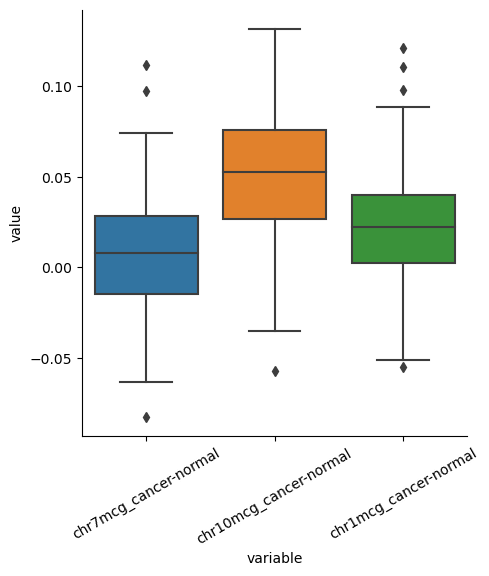

In [66]:
sample = 'MGH105'
tmp = mcg_chr10[['chr7mcg_cancer-normal','chr10mcg_cancer-normal',
                  'chr1mcg_cancer-normal','Sample','malignancy']]
tmp = tmp[(tmp['Sample'] == sample)&(tmp['malignancy'] == 'malignant')]

tmp = pd.melt(tmp,id_vars=['Sample','malignancy'], value_vars = ['chr7mcg_cancer-normal','chr10mcg_cancer-normal',
                  'chr1mcg_cancer-normal'])

ax = sns.catplot(data = tmp, kind = 'box', x='variable', y = 'value')
#sns.catplot(data = tmp, kind = 'swarm', x='variable', y = 'value')
ax.set_xticklabels(ax.axes.flat[0].get_xticklabels(),rotation = 30)


In [62]:
tmp

,Sample,malignancy,variable,value
0,MGH64,malignant,chr7mcg_cancer-normal,0.127009
1,MGH64,malignant,chr7mcg_cancer-normal,0.075836
2,MGH64,malignant,chr7mcg_cancer-normal,0.065038
3,MGH64,malignant,chr7mcg_cancer-normal,0.115698
4,MGH64,malignant,chr7mcg_cancer-normal,0.073316
...,...,...,...,...
190,MGH64,malignant,chr1mcg_cancer-normal,0.068185
191,MGH64,malignant,chr1mcg_cancer-normal,0.082172
192,MGH64,malignant,chr1mcg_cancer-normal,0.059155
193,MGH64,malignant,chr1mcg_cancer-normal,0.019995


In [39]:
from scipy.stats import wilcoxon


In [67]:
a = tmp[tmp['variable']=='chr7mcg_cancer-normal']['value']
b = tmp[tmp['variable']=='chr1mcg_cancer-normal']['value']
wilcoxon(a,b)

WilcoxonResult(statistic=2540.0, pvalue=2.7856101816578995e-28)

In [68]:
a = tmp[tmp['variable']=='chr10mcg_cancer-normal']['value']
b = tmp[tmp['variable']=='chr1mcg_cancer-normal']['value']
wilcoxon(a,b)

WilcoxonResult(statistic=858.0, pvalue=2.0982281797542793e-36)

In [65]:
len(a)

65

# chr6 cnv

In [71]:
mcds_chr = mcds.sel(chrom100k= (mcds['chrom100k_chrom'].values=='chr6'))
mcds_chr

<xarray.MCDS>
Dimensions:                  (cell: 1578, chrom100k: 1678, count_type: 2)
Coordinates: (12/19)
  * cell                     (cell) object 'GBM_MGH105C_A1_S1_L008.ACAACC' .....
  * chrom100k                (chrom100k) <U10 'chr6_0' 'chr6_1' ... 'chr6_1708'
    chrom100k_chrom          (chrom100k) <U5 dask.array<chunksize=(1678,), meta=np.ndarray>
    chrom100k_end            (chrom100k) int64 dask.array<chunksize=(1678,), meta=np.ndarray>
    chrom100k_start          (chrom100k) int64 dask.array<chunksize=(1678,), meta=np.ndarray>
  * count_type               (count_type) <U3 'mc' 'cov'
    ...                       ...
    cell_umap_1              (cell) float64 9.681 9.954 10.27 ... 10.05 9.041
    cell_leiden              (cell) float64 11.0 1.0 1.0 1.0 ... 12.0 1.0 1.0
    cell_CellAssignment      (cell) object 'MES.1' 'MES.2' ... 'NPC.1' 'MES.2'
    cell_G1S                 (cell) float64 -0.1016 -0.1176 ... -0.1523 -0.9441
    cell_G2M                 (cell) float64 0.06292 0.06021 ... -0.5765 -0.7163
    cell_malignancy          (cell) object 'malignant' ... 'malignant'
Data variables:
    chrom100k_da             (cell, chrom100k, count_type) uint32 dask.array<chunksize=(1578, 1678, 2), meta=np.ndarray>
Attributes:
    obs_dim:  cell
    var_dim:  chrom100k

In [ ]:
mcds_7_1 = mcds_chr.sel(chrom100k = mcds_chr['chrom100k'][:700],count_type = 'mc').sum(dim='chrom100k').to_pandas()
mcds_7_2 = mcds_chr.sel(chrom100k = mcds_chr['chrom100k'][700:],count_type = 'mc').sum(dim='chrom100k').to_pandas()
covcg_df_1 = mcds_chr.sel(chrom100k = mcds_chr['chrom100k'][:700],count_type = 'cov').sum(dim='chrom100k').to_pandas()
covcg_df_2 = mcds_chr.sel(chrom100k = mcds_chr['chrom100k'][700:],count_type = 'cov').sum(dim='chrom100k').to_pandas()
chrm_1 = pd.DataFrame(mcds_7_1['chrom100k_da'].div(covcg_df_1['chrom100k_da']))
chrm_1.columns = ['chr7_1_mcg']
chrm_2 = pd.DataFrame(mcds_7_2['chrom100k_da'].div(covcg_df_2['chrom100k_da']))
chrm_2.columns = ['chr7_2_mcg']

chrm7 = chrm_1.join(chrm_2)
chrm7 = chrm7.join(metadata[['type','Sample']])
chrm7